# Supplementary code to arXiv:2402.13999


Suppose we have a feature map $\phi\colon\mathbf R^d \to\mathbf R^p$ on which we can perform ridge regression with $n$ samples $(x_i,y_i)$, $i=1,\ldots,n$. By the representer theorem we know that

$$
f(x) = \sum_{i=1}^n\alpha_i \phi(x)^\top\phi(x_i),
$$

so that minimizing

$$
\begin{split}
\sum_j (y_j - f(x_j))^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2 &= \sum_j (y_j - \sum_{i=1}^n \phi(x_j)^\top\phi(x_i)\alpha_i)^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2\\
& = \lVert y - \Phi^\top\Phi \alpha\rVert^2 + \lambda \lVert\Phi\alpha\rVert^2,
\end{split}
$$

with $\Phi:=(\phi(x_1),\cdots,\phi(x_n))\in\mathbf R^{p\times n}$, with respect to $\alpha$ yields

$$
\hat\alpha := (\Phi^\top\Phi + \lambda I)^{-1}y, \quad \hat f(x) = \phi(x)^\top\Phi (\Phi^\top\Phi + \lambda I)^{-1}y= \phi(x)^\top (\Phi \Phi^\top + \lambda I)^{-1}\Phi y.
$$

Our theorem from https://arxiv.org/abs/2402.13999 gives a theoretical prediction for the generalization error

$$
    \mathcal E_\mathrm{gen} := \mathbf E_{x',y'} (y' - \hat f(x'))^2 = \mathbf E_{x',y'} (y' - \phi(x')^\top\hat \alpha)^2 = \sigma^2 + \hat\alpha^\top\Omega\hat\alpha - 2 \psi^\top\hat \alpha,
$$

where

$$
    \mathbf E \phi(x)\phi(x)^\top = \Omega, \qquad \mathbf E \phi(x) = 0, \qquad \mathbf E \phi(x)y = \psi,\qquad \mathbf E y^2 = \sigma^2,
$$

in terms of the formula

$$
    \mathcal E_\mathrm{gen}^\mathrm{rmt}:=\frac{ \sigma^2 -  n\lambda m\psi^\top (M+\lambda M^2)\psi }{1-n(m\lambda)^2\operatorname{Tr} \Omega M\Omega M}.
$$

Here $M,m$ are defined by

$$
    \frac{1}{m(\lambda)} = \lambda + \operatorname{Tr} \Omega (1 + n m(\lambda)\Omega )^{-1}, \quad M(\lambda) := (\lambda + \lambda n m(\lambda)\Omega )^{-1},
$$


# Imports


In [1]:
! pip install typst icecream pyobsplot line_profiler -q
! apt-get install -y ca-certificates curl gnupg
! mkdir -p /etc/apt/keyrings
! curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg
! echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_18.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list
! apt-get update
! apt-get install -y nodejs
! npm install -g npm
! npm install pyobsplot
! rm -rf "feature-ridge-regression"
! git clone https://github.com/wirhabenzeit/feature-ridge-regression.git
%cd feature-ridge-regression


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 714.8/714.8 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.6/730.6 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.16).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to

In [2]:
import numpy as np
import polars as pl
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from scipy.interpolate import interp1d
from scipy.integrate import quad_vec
from scipy.optimize import minimize_scalar
from tqdm import tqdm
from obsplot import Obsplot, js, Plot
from regression import FeatureRidgeRegression

obsplot = Obsplot(font="Liberation Sans")

# Auxilliary functions


In [4]:
class SaveFeatures(keras.callbacks.Callback):
    def __init__(self, save_callback):
        self.log = dict()
        self.n_epochs = 0
        self.n_steps = 0
        self.save_callback = save_callback

    def save(self):
        if res := self.save_callback(self.model, n_epoch=self.n_epochs, n_step=self.n_steps):
            self.log[(self.n_epochs, self.n_steps)] = res

    def on_train_begin(self, logs=None):
        self.steps_per_epoch = self.n_steps

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epochs = epoch
        self.n_steps = 0

    def on_train_batch_begin(self, batch, logs=None):
        self.save()
        self.n_steps += 1

    def on_train_end(self, logs=None):
        self.n_epochs += 1
        self.n_steps = 0
        self.save()

In [5]:
def rational_log_space(max_val, denom=10, num_val=100):
    return (np.unique(np.geomspace(1, max_val * denom + 1, num_val, dtype=int)) - 1) / denom


def rational_pow_space(max_val, denom=10, pow=2, num_val=100):
    return np.unique(np.round(np.linspace(0, (max_val * denom) ** (1 / pow), num_val) ** pow)) / denom


def choose(arr, num):
    return [list(arr)[i] for i in np.round(np.linspace(0, len(arr) - 1, num)).astype(int)]

In [6]:
def normalize(images):
    mz = images - np.mean(images, axis=0)
    return mz / mz.std()


def random_split(prop, images, labels):
    rng = np.random.default_rng()
    choice = rng.choice(list(prop.keys()), p=list(prop.values()), size=len(labels))
    return {k: (images[choice == k], labels[choice == k]) for k in prop.keys()}

## Data Import


In [7]:
def filter(images, labels, class_names, class_map):
    filtered_idx = [i for i, label in enumerate(labels) if class_names[label] in class_map]
    return images[filtered_idx], np.array([class_map[class_names[label]] for label in labels[filtered_idx]])


def getData(
    name="fashion-MNIST",
    class_map={"Shirt": -1, "T-shirt/top": -1, "Pullover": 1, "Coat": 1},
):
    if name == "fashion-MNIST":
        fashion_mnist = keras.datasets.fashion_mnist
        (
            (train_images, train_labels),
            (test_images, test_labels),
        ) = fashion_mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]
        return filter(images, labels, class_names, class_map)
    if name == "MNIST":
        mnist = keras.datasets.mnist
        (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = list(range(10))
        return filter(images, labels, class_names, class_map)
    raise ValueError("Unsupported Dataset")

In [8]:
f_images, f_labels = getData(name="MNIST", class_map={i: (1 if i % 2 == 0 else -1) for i in range(10)})
f_images = normalize(f_images)
data = random_split({"test": 0.1, "train_reg": 0.25, "train_w": 0.25, "emp_cov": 0.4}, f_images, f_labels)

11490434/11490434 [==============================] - 2s 0us/step


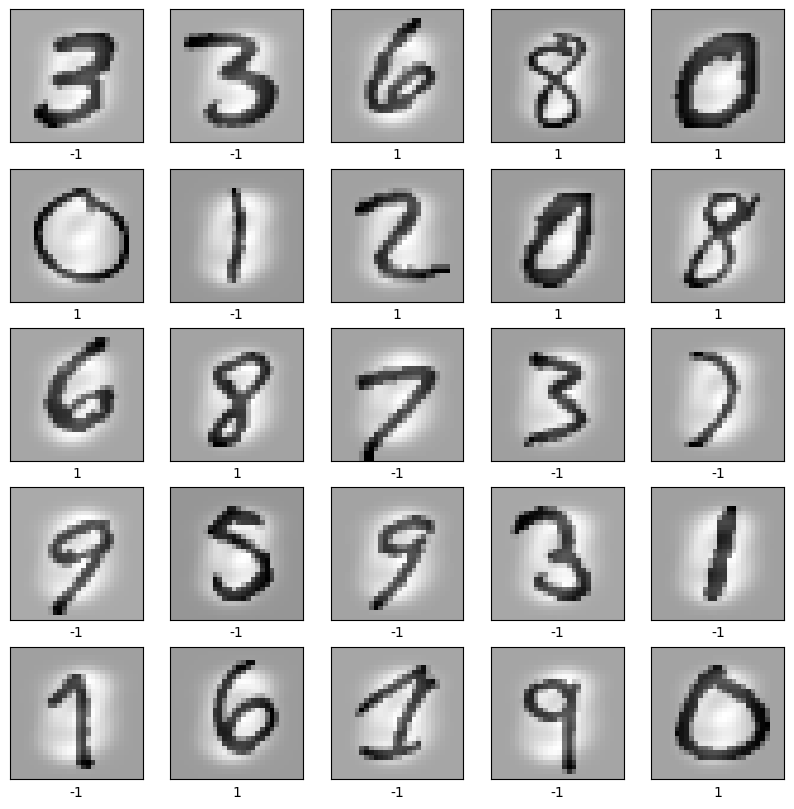

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(data["test"][1][i])
plt.show()

# Model Def & Training


In [10]:
model_dim = 2352
n_epochs = 70
batch_size = 128
train_data = data["train_w"]
num_steps = np.ceil(len(train_data[1]) / batch_size)
n_callbacks = 70

model = keras.Sequential(
    [
        keras.Input(shape=f_images.shape[1:]),
        keras.layers.Flatten(),
        keras.layers.Dense(model_dim, activation="relu", use_bias=False),
        keras.layers.Dense(model_dim, activation="relu", use_bias=False),
        keras.layers.Dense(1, use_bias=False),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")


def save_callback(model, n_epoch=0, n_step=0):
    if n_epoch + n_step / num_steps not in rational_log_space(n_epochs, denom=num_steps, num_val=n_callbacks):
        return
    acc = model.evaluate(*data["test"])
    return {
        "reg": FeatureRidgeRegression.empirical(
            model,
            train_data=data["train_reg"],
            test_data=data["test"],
            emp_avg_data=data["emp_cov"],
        ),
        "loss": acc,
    }


regressions = SaveFeatures(save_callback)
history = keras.callbacks.History()

model.fit(
    *train_data,
    epochs=n_epochs,
    validation_data=data["test"],
    batch_size=batch_size,
    verbose=1,
    shuffle=True,
    callbacks=[regressions, history],
)

Epoch 1/70
  6/136 [>.............................] - ETA: 8:46 - loss: 14.8766

136/136 [==============================] - 116s 811ms/step - loss: 0.2095 - val_loss: 0.2043
Epoch 2/70
136/136 [==============================] - 22s 161ms/step - loss: 0.1280 - val_loss: 0.1301
Epoch 3/70
136/136 [==============================] - 13s 99ms/step - loss: 0.1043 - val_loss: 0.1103
Epoch 4/70
136/136 [==============================] - 9s 67ms/step - loss: 0.0896 - val_loss: 0.1101
Epoch 5/70
136/136 [==============================] - 9s 65ms/step - loss: 0.0809 - val_loss: 0.0993
Epoch 6/70
136/136 [==============================] - 5s 35ms/step - loss: 0.0642 - val_loss: 0.0871
Epoch 7/70
136/136 [==============================] - 4s 32ms/step - loss: 0.0527 - val_loss: 0.0840
Epoch 8/70
136/136 [==============================] - 5s 40ms/step - loss: 0.0402 - val_loss: 0.0770
Epoch 9/70
136/136 [==============================] - 4s 32ms/step - loss: 0.0361 - val_loss: 0.0660
Epoch 10/70
136/136 [==============================] - 4s 32ms/step - loss: 0.0349 - val_loss: 0

In [11]:
obsplot(
    {
        "marks": [
            Plot.lineY(
                pl.DataFrame(history.history).with_columns(pl.Series("epoch", range(n_epochs))).melt(id_vars="epoch"),
                dict(x="epoch", y="value", stroke="variable"),
            )
        ],
        "title": "Training History",
        "color": {"legend": True, "type": "categorical"},
        "y": {"type": "log", "label": "loss"},
        "grid": True,
    },
    path="test.svg",
)

# Real Data Feature Regression


In [12]:
regs = [0.1, 1, 10]
regsLin = [1, 10, 200]
nsRMT = np.unique(np.geomspace(10, 10_000, 200, dtype=int))
nsEmp = np.unique(np.geomspace(10, len(data["train_reg"][1]) / 2, 30, dtype=int))

In [13]:
linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)
linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
linear_regression = FeatureRidgeRegression.empirical(
    linear_model,
    train_data=data["train_reg"],
    test_data=data["test"],
    emp_avg_data=data["emp_cov"],
)
df_real_lin_reg = linear_regression.learningCurve(lambdas=regsLin, ns=nsRMT, ns_emp=nsEmp, repeats=3)
df_real_lin_reg.write_csv("data/real_lin_reg.csv")

In [14]:
df_real_emp = pl.concat(
    [
        data["reg"]
        .learningCurve(
            lambdas=regs,
            ns=nsRMT,
            ns_emp=nsEmp,
            repeats=5,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)
df_real_emp.write_csv("data/real_emp.csv")

100%|██████████| 5/5 [02:43<00:00, 32.69s/it]


In [16]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb}`"))
obsplot(
    {
        "marks": [
            Plot.line(df_real_emp, xstroke | {"y": "genErrRMT", "fx": "epoch+step"}),
            Plot.dot(df_real_emp, xstroke | {"y": "genErrEmp", "fx": "epoch+step"}),
            Plot.line(df_real_lin_reg, xstroke | {"y": "genErrRMT", "fx": js("d=>'Linear Regression'")}),
            Plot.dot(df_real_lin_reg, xstroke | {"y": "genErrEmp", "fx": js("d=>'Linear Regression'")}),
            Plot.ruleY(df_real_emp, {"y": "loss", "fx": "epoch+step", "stroke": js("d=>'NN loss'")}),
        ],
        "color": {"legend": True, "type": "categorical"},
        "width": 1200,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 1.6], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "Epoch"},
        "title": "Generalization error of feature ridge regression",
        "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent. The colors encode the size of the regularization parameter of ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of steps of gradient descent (the facet titles have the format 'epoch'.'step'). The horizontal lines represent the loss of the neural network on the test set.",
    },
    path="figures/real_emp.pdf",
)

In [17]:
df_real_det = pl.concat(
    [
        data["reg"]
        .learningCurve(
            lambdas=regs,
            ns=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(regressions.log.items())
    ],
    how="diagonal_relaxed",
)
df_real_det.write_csv("data/real_det.csv")

100%|██████████| 61/61 [00:11<00:00,  5.21it/s]


In [18]:
obsplot(
    {
        "marks": [
            Plot.line(
                df_real_det.sort("epoch+step", descending=True),
                dict(x="n", y="genErrRMT", stroke="epoch+step", fx="lamb", opacity=0.8),
            ),
        ],
        "color": {"legend": True, "label": "Epoch", "type": "log"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0, 1.2], "label": "Generalization error"},
        "grid": True,
        "fx": {"label": "λ"},
        "title": "Deterministic equivalent of the generalization error",
        "subtitle": "The plot shows the dynamics of the learning curves over the training epochs for various regularization parameters.",
    },
    path="figures/real_det.pdf",
)

## Optimal $\lambda$


In [42]:
nsRMT = np.logspace(1, 3.5, 30).astype(int)
df_real_opt_lin = linear_regression.learningCurve(ns=nsRMT, ns_emp=nsRMT, repeats=3)
df_real_opt_emp = pl.concat(
    [
        data["reg"]
        .learningCurve(
            ns=nsRMT,
            ns_emp=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)
df_real_opt_emp.write_csv("data/real_opt_emp.csv")
df_real_opt_lin.write_csv("data/real_opt_lin.csv")


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


In [20]:
obsplot(
    {
        "marks": [
            Plot.line(df_real_opt_emp, dict(x="n", y="genErrRMT", opacity=1, fx="epoch+step")),
            Plot.dot(df_real_opt_emp, dict(x="n", y="genErrEmp", stroke="lamb", fx="epoch+step")),
            Plot.ruleY(df_real_opt_emp, dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
            Plot.line(df_real_opt_lin, dict(x="n", y="genErrRMT", fx=js("d=>'Linear Regression'"))),
            Plot.dot(df_real_opt_lin, dict(x="n", y="genErrEmp", stroke="lamb", fx=js("d=>'Linear Regression'"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 0.8], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "width": 1000,
        "height": 700,
        "color": {"legend": True, "type": "log", "label": "λ"},
        "title": "Generalization error at optimal regularisation (real data)",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
    },
    path="figures/real_opt_emp.pdf",
)

In [21]:
df_real_opt_det = pl.concat(
    [
        data["reg"]
        .learningCurve(ns=nsRMT)
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(regressions.log.items())
    ],
    how="diagonal_relaxed",
)
df_real_opt_det.write_csv("data/real_opt_det.csv")

100%|██████████| 61/61 [01:10<00:00,  1.16s/it]


In [22]:
obsplot(
    {
        "marks": [
            Plot.line(df_real_opt_lin, dict(x="n", y="genErrRMT", opacity=1, strokeDasharray=[5, 5])),
            Plot.line(df_real_opt_det, dict(x="n", y="genErrRMT", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0, 1.1], "label": "Generalization error"},
        "grid": True,
        "fx": {"label": "λ"},
        "color": {"legend": True, "type": "log", "label": "Epoch"},
        "title": "Generalization error at optimal regularisation",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
    },
    path="figures/real_opt_det.pdf",
)

# Artificial Data Feature Regression


In [43]:
def gen_labels(x, model=None, source="model"):
    features = None
    if source == "model":
        feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        features = feature_model(x).numpy()
    elif source == "model_tanh":
        features = np.tanh(np.tanh(x.reshape(x.shape[0], -1) @ model.layers[1].weights[0].numpy()) @ model.layers[2].weights[0].numpy())
    elif source == "linear":
        features = x.reshape(x.shape[0], -1)
    elif source == "rf_keras":
        feature_model = keras.Sequential(
            [
                keras.Input(shape=(28, 28)),
                keras.layers.Flatten(),
                keras.layers.Dense(2352, activation="tanh", use_bias=False),
            ]
        )
        feature_model.compile(optimizer="adam", loss="mean_squared_error")
        features = feature_model(x).numpy()
    elif source == "rf":
        w = np.random.normal(0, 1, (x.shape[1] ** 2, 800)) / 800**0.5
        features = np.tanh(x.reshape(x.shape[0], -1) @ w)
    else:
        raise ValueError("Invalid Source")
    theta = np.random.normal(0, 1, features.shape[1])
    labels = np.dot(features, theta)
    labels -= labels.mean()
    labels /= labels.std()
    return labels

In [44]:
n_samples = 300_000
sample_dim = (28, 28)
flat_images = f_images.reshape(f_images.shape[0], -1)
pop_cov = flat_images.T @ flat_images / flat_images.shape[0]
pop_mean = flat_images.mean(axis=0)
images_artificial = np.random.multivariate_normal(pop_mean, pop_cov, n_samples).reshape(n_samples, *sample_dim)
labels_artificial = gen_labels(images_artificial, source="rf")

data_artificial = random_split({"test": 0.1, "train_reg": 0.1, "train_w": 0.6, "emp_cov": 0.2}, images_artificial, labels_artificial)

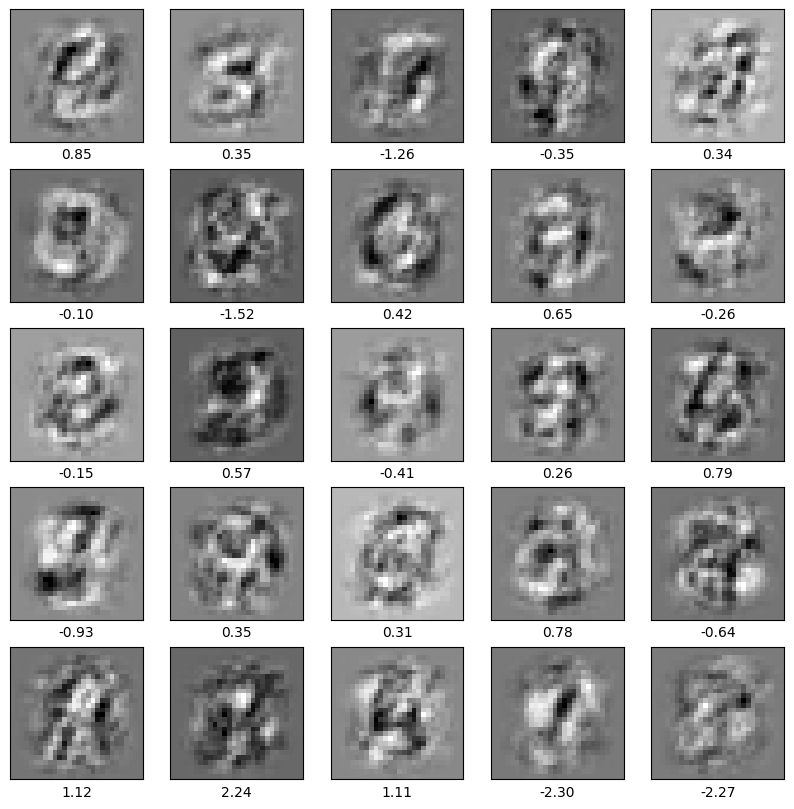

In [45]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_artificial["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(f"{data_artificial['test'][1][i]:.2f}")
plt.show()

In [46]:
new_linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)
new_linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
new_linear_regression = FeatureRidgeRegression.empirical(
    new_linear_model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"]
)

In [47]:
n_epochs = 15
batch_size = 128
train_data = data_artificial["train_w"]
num_steps = np.ceil(len(train_data[1]) / batch_size)

new_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(
            800,
            activation="tanh",
            use_bias=False,
        ),
        keras.layers.Dense(
            700,
            activation="tanh",
            use_bias=False,
        ),
        keras.layers.Dense(1, use_bias=False),
    ]
)

new_model.compile(optimizer="adam", loss="mean_squared_error")


def lin_save_callback(model, n_epoch=0, n_step=0):
    if n_epoch + n_step / num_steps not in rational_log_space(n_epochs, denom=num_steps, num_val=20):
        return
    acc = model.evaluate(*data_artificial["test"])
    return {
        "reg_emp": FeatureRidgeRegression.empirical(
            model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"]
        ),
        "reg_lin": FeatureRidgeRegression.linearized(
            model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"], avg=False
        ),
        "loss": acc,
    }


lin_regressions = SaveFeatures(lin_save_callback)
history = keras.callbacks.History()

new_model.fit(
    *train_data,
    epochs=n_epochs,
    validation_data=data_artificial["test"],
    batch_size=batch_size,
    verbose=1,
    shuffle=True,
    callbacks=[lin_regressions, history],
)

Epoch 1/15
   4/1403 [..............................] - ETA: 1:20:17 - loss: 3.4075

1403/1403 [==============================] - 74s 48ms/step - loss: 0.0658 - val_loss: 0.0640
Epoch 2/15
1403/1403 [==============================] - 15s 11ms/step - loss: 0.0548 - val_loss: 0.0558
Epoch 3/15
1403/1403 [==============================] - 5s 3ms/step - loss: 0.0476 - val_loss: 0.0559
Epoch 4/15
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0467 - val_loss: 0.0567
Epoch 5/15
1403/1403 [==============================] - 5s 3ms/step - loss: 0.0426 - val_loss: 0.0489
Epoch 6/15
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0428 - val_loss: 0.0528
Epoch 7/15
1403/1403 [==============================] - 5s 3ms/step - loss: 0.0379 - val_loss: 0.0543
Epoch 8/15
1403/1403 [==============================] - 5s 3ms/step - loss: 0.0348 - val_loss: 0.0522
Epoch 9/15
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0450 - val_loss: 0.0494
Epoch 10/15
1403/1403 [==============================] - 5s 3ms/step - loss: 0.0301 - 

In [48]:
obsplot(
    {
        "marks": [
            Plot.lineY(
                pl.DataFrame(history.history).with_columns(pl.Series("epoch", range(n_epochs))).melt(id_vars="epoch"),
                dict(x="epoch", y="value", stroke="variable"),
            )
        ],
        "title": "Training History",
        "color": {"legend": True, "type": "categorical"},
        "y": {"type": "log", "label": "loss"},
        "grid": True,
    }
)

In [49]:
nsRMT = np.unique(np.geomspace(300, 5_000, 200, dtype=int))
nsEmp = np.unique(np.geomspace(300, 5_000, 15, dtype=int))
regs = [1, 10, 100]
regsReg = [0.1, 1, 10]

df_art_emp = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(regs, ns=nsRMT, ns_emp=nsEmp, repeats=1)
        .join(data["reg_lin"].learningCurve(regs, ns=nsRMT).rename({"genErrRMT": "genErrRMTlin"}), on=("lamb", "n"), how="outer")
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(lin_regressions.log.items(), 4))
    ],
    how="vertical_relaxed",
)
df_art_emp.write_csv("data/art_emp.csv")


100%|██████████| 4/4 [00:24<00:00,  6.09s/it]


In [50]:
df_art_lin = new_linear_regression.learningCurve(regsReg, ns=nsRMT, ns_emp=nsEmp, repeats=5)
df_art_lin.write_csv("data/art_lin.csv")

In [51]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb}`"))
obsplot(
    {
        "marks": [
            Plot.line(df_art_emp, xstroke | {"y": "genErrRMT", "fx": "epoch+step"}),
            Plot.line(
                df_art_emp,
                xstroke | {"y": "genErrRMTlin", "fx": "epoch+step", "strokeDasharray": "5,5"},
            ),
            Plot.dot(df_art_emp, xstroke | {"y": "genErrEmp", "fx": "epoch+step", "symbol": js("d=>'Feature Regression'")}),
            Plot.line(
                df_art_lin,
                xstroke | {"y": "genErrRMT", "fx": js("d=>'Linear Regression'")},
            ),
            Plot.dot(
                df_art_lin,
                xstroke | {"y": "genErrEmp", "fx": js("d=>'Linear Regression'"), "symbol": js("d=>'Linear Regression'")},
            ),
            Plot.ruleY(
                df_art_emp,
                {"y": "loss", "fx": "epoch+step", "stroke": js("d=>'NN loss'")},
            ),
        ],
        "color": {"legend": True, "type": "categorical"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "grid": True,
        "fx": {"label": "Epoch"},
        "title": "Generalization error of feature ridge regression",
        "y": {"label": "Generalization error", "type": "log", "domain": [0.03, .8]},
        "symbol": {"legend": True},
        "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent (solid with empirical and dashed with linearized covariance). The colors encode the size of the regularization parameter used for ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of epochs of gradient descent. The horizontal lines represent the loss of the neural network on the test set.",
    },
    path="figures/art_emp.pdf",
)

In [52]:
df_art_det = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(
            lambdas=regs,
            ns=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(lin_regressions.log.items())
    ],
    how="diagonal_relaxed",
)


100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


In [53]:
obsplot(
    {
        "marks": [
            Plot.line(
                df_art_det.sort("epoch+step", descending=True),
                dict(x="n", y="genErrRMT", stroke="epoch+step", fx="lamb", opacity=0.8),
            ),
        ],
        "color": {"legend": True, "label": "Epoch", "type": "log"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.02, .4], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "title": "Deterministic equivalent of the generalization error",
        "subtitle": "The plot shows the dynamics of the learning curves over the training epochs for various regularization parameters.",
    },
    path="figures/art_det.pdf",
)

## Optimal $\lambda$


In [58]:
nsRMT = np.geomspace(100, 20_000, 100, dtype=int)
nsEmp = np.geomspace(100, 20_000, 15, dtype=int)
df_art_opt_lin = new_linear_regression.learningCurve(ns=nsRMT, ns_emp=nsEmp, repeats=3)
df_art_opt_emp = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(
            ns=nsRMT,
            ns_emp=nsEmp,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(lin_regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)
df_art_opt_emp.write_csv("data/art_opt_emp.csv")


100%|██████████| 5/5 [00:42<00:00,  8.44s/it]


In [59]:
obsplot(
    {
        "marks": [
            Plot.line(df_art_opt_emp, dict(x="n", y="genErrRMT", opacity=1, fx="epoch+step")),
            Plot.dot(df_art_opt_emp, dict(x="n", y="genErrEmp", stroke="lamb", fx="epoch+step")),
            Plot.ruleY(df_art_opt_emp, dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
            Plot.line(df_art_opt_lin, dict(x="n", y="genErrRMT", fx=js("d=>'Linear Regression'"))),
            Plot.dot(df_art_opt_lin, dict(x="n", y="genErrEmp", stroke="lamb", fx=js("d=>'Linear Regression'"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 0.6], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "width": 1000,
        "height": 700,
        "color": {"legend": True, "type": "log", "label": "λ"},
        "title": "Generalization error at optimal regularisation (artificial data)",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
    },
    path="figures/art_opt_emp.pdf",
)

In [56]:
df_art_opt_det = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(ns=nsRMT)
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(lin_regressions.log.items())
    ],
    how="diagonal_relaxed",
)
df_art_opt_det.write_csv("data/art_opt_det.csv")


100%|██████████| 19/19 [01:49<00:00,  5.78s/it]


In [57]:
obsplot(
    {
        "marks": [
            Plot.line(df_art_opt_lin, dict(x="n", y="genErrRMT", opacity=1, strokeDasharray=[5, 5])),
            Plot.line(df_art_opt_det, dict(x="n", y="genErrRMT", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.05, 0.6], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "color": {"legend": True, "type": "log", "label": "Epoch"},
        "title": "Generalization error at optimal regularisation",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
    },
    path="figures/art_opt_det.pdf",
)